# Airfoil Self_Noise

In [1]:
# Imports
import numpy as np
import pandas as pd
from io import StringIO

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, KFold, cross_val_score

## First reading file data and save it as dataframe

In [2]:
Dataset=r'airfoil_self_noise.dat'

In [3]:
# Split Data , AS it reads text from file as one object
with open(Dataset, 'r') as f:
    text = f.read()
    values=text.split()

In [4]:
df = pd.read_csv(StringIO(text), 
                 sep="\s+",  
                 usecols=range(6), 
                 names=['Frequency','AngleOfAtt','ChordL','Free-stream V','SSDThickness','SSPLevel'])

In [5]:
df.head()

,Frequency,AngleOfAtt,ChordL,Free-stream V,SSDThickness,SSPLevel
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Dataset Description :
<li>Nasa predicts the sound pressure level in decibles</li>
<li>Dataset consists of 6 Attruibutes and 1503 instance</li> 
<li>First 5 attruibutes represents the physical features of sound wave and last attributes is the goal value to predict  </li>

# Data Wrangling 

The list of attributes are 
<ol>
  <li>Frequency in HZ</li>
  <li>Angle of attack in degrees</li>
  <li>Chord length in meter</li>
  <li>Free-stream velocity, in meters per second</li>
  <li>Suction side displacement thickness in meters</li>
  <li>Scaled sound pressure level, in decibels</li>
</ol>

In [6]:
# First checking the types of colums
df.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

**All the data are numerical**

In [7]:
# Display the information of the dataframe 
df.isnull().sum()

Frequency        0
AngleOfAtt       0
ChordL           0
Free-stream V    0
SSDThickness     0
SSPLevel         0
dtype: int64

**There's no missing data in any of the features in the dataset**

# Data  Visualization

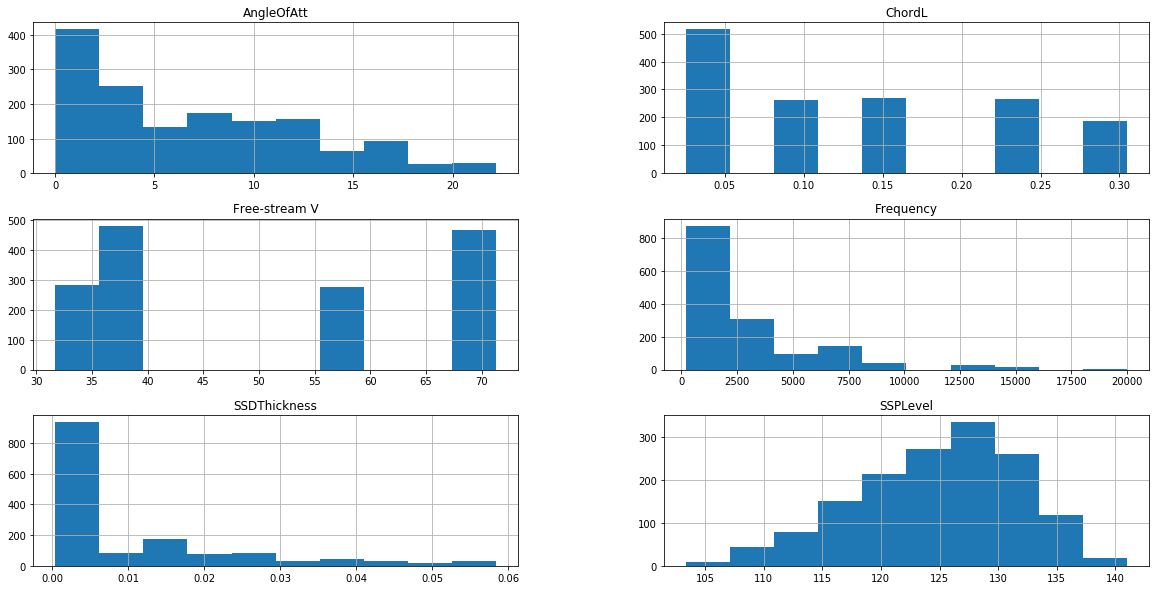

In [8]:
df.hist(figsize=(20, 10))
plt.show()

In [9]:
pd.value_counts(df['SSDThickness']>0.03)

False    1349
True      154
Name: SSDThickness, dtype: int64

**As shown in the graphs above, we have some extreme values but they somehow follow the distribution of the data**

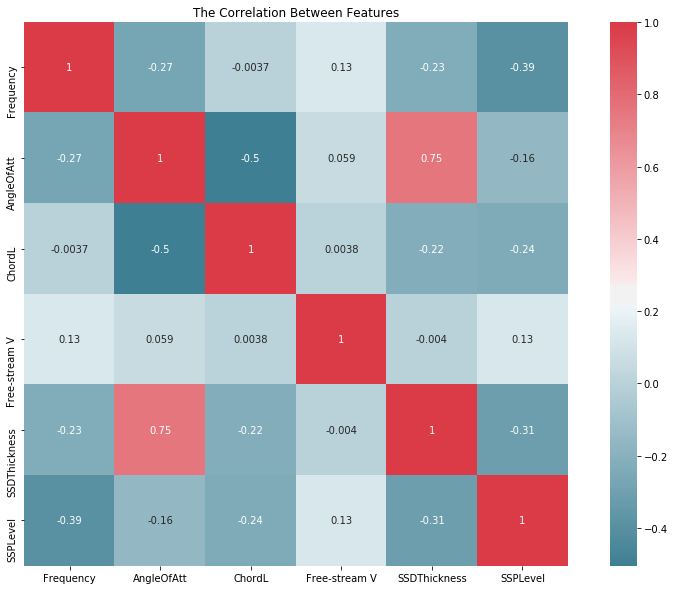

In [10]:
f, ax = plt.subplots(figsize=(15, 10))
corr = df.corr()
sns.heatmap(corr, annot=True, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('The Correlation Between Features')
plt.show()

According to the **Correlation** matrix, there is a *negative correlation* betwee the target columns **SSPLevel** and **Frequency** and **SSDThickness**

## preprocessing

In [11]:
# calculates the rmse between the predictions and actual values
def rmse(y_pred, y):
    return np.sqrt(mean_squared_error(y_pred, y))

# gets the predictions using x and the estimator and then calculates rmse between the predictions and y
def rmse_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return rmse(y_pred,y)

# Organizes the importance data coming from RandomForest into a dataframe
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns[:-1], 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [12]:
# First Divding the dataset to x and y 
x = df.iloc[:,:-1]
y = df.iloc[:, -1]

In [13]:
#Spliting the dataset into 80% training and 20% testing data
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_valid.shape)

(1202, 5) (301, 5)


In [14]:
x_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
x_valid = x_scaler.transform(x_valid)

**Scaling the data using StandarScaler**
- Fiting the scaler on the training features
- Transforming the validation features


In [15]:
x_train.shape, x_valid.shape

((1202, 5), (301, 5))

# Models 

# Random Forest

Training Different **Random Forest models** by changing the `n_estimators` parameter and saving the scores

In [16]:
train_scores = []
valid_scores = []

best_valid = np.inf
best_rf = None

n_estimators = range(120, 260, 20) 

j = 0
for i in n_estimators:
    rf = RandomForestRegressor(n_jobs=-1, n_estimators=i, criterion='mae', random_state=42)
    rf.fit(x_train, y_train);
    train_score = rmse_scorer(rf, x_train, y_train)
    valid_score = rmse_scorer(rf, x_valid, y_valid)
    train_scores.append(train_score)
    valid_scores.append(valid_score) 
    print(f"Iteration: {j+1}\t | n_estimators: {i}\t | train score: {train_score:.4f}\t | valid score: {valid_score:.4f}")
    j+=1
    
    # keeping the best model on the valid dataset
    if valid_score < best_valid:
        best_valid = valid_score
        best_rf = rf

Iteration: 1	 | n_estimators: 120	 | train score: 0.7410	 | valid score: 1.8026
Iteration: 2	 | n_estimators: 140	 | train score: 0.7421	 | valid score: 1.8000
Iteration: 3	 | n_estimators: 160	 | train score: 0.7310	 | valid score: 1.7916
Iteration: 4	 | n_estimators: 180	 | train score: 0.7332	 | valid score: 1.7980
Iteration: 5	 | n_estimators: 200	 | train score: 0.7287	 | valid score: 1.8066
Iteration: 6	 | n_estimators: 220	 | train score: 0.7318	 | valid score: 1.8020
Iteration: 7	 | n_estimators: 240	 | train score: 0.7346	 | valid score: 1.8054


In [17]:
print(f'Best valid {best_valid:.4f}')

Best valid 1.7916


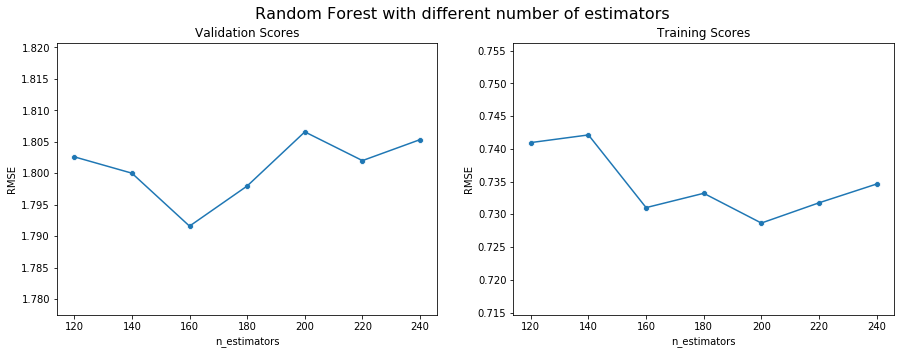

In [18]:
n_x = n_estimators
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Random Forest with different number of estimators', fontsize=16)

sns.scatterplot(ax=axes[0], x=n_x, y=valid_scores)
sns.lineplot(ax=axes[0], x=n_x, y=valid_scores)
axes[0].set_title('Validation Scores')
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('RMSE')

sns.scatterplot(ax=axes[1], x=n_x, y=train_scores)
sns.lineplot(ax=axes[1], x=n_x, y=train_scores)
axes[1].set_title('Training Scores')
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('RMSE')
plt.show()

In [19]:
# getting the feature importance from RandomForest
fi = rf_feat_importance(best_rf, df)

In [20]:
fi

,cols,imp
0,Frequency,0.406203
4,SSDThickness,0.358320
2,ChordL,0.101510
3,Free-stream V,0.072522
1,AngleOfAtt,0.061444


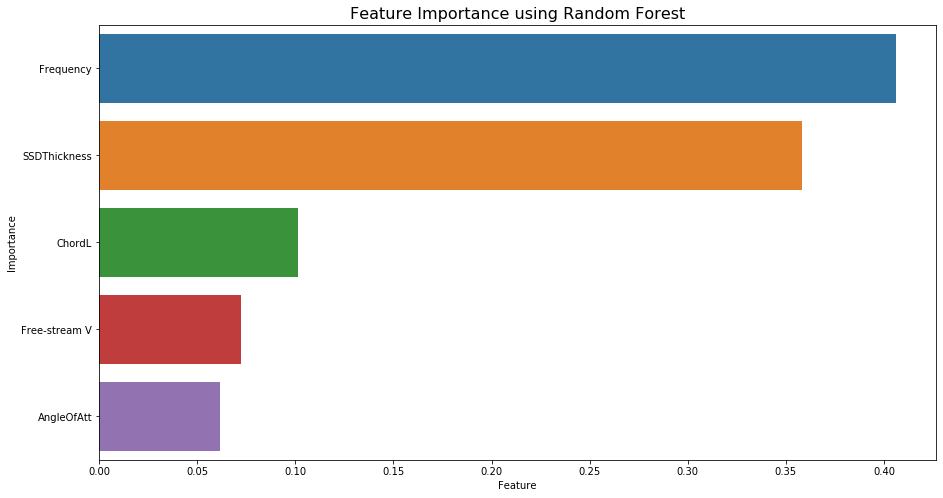

In [23]:
plt.figure(figsize=(15, 8))
sns.barplot(x='imp', y='cols', data=fi, orient = 'h')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance using Random Forest', fontsize=16)
plt.show()

### Support Vector Machine 
Training Different **Support Vector Machine** by changing the `kernel` parameter

In [24]:
train_scores = []
valid_scores = []

best_valid = np.inf
best_svr = None

kernels = ["linear", "poly", "rbf", "sigmoid"] 

j = 0
for i in kernels:
    svr = SVR(kernel=i)
    svr.fit(x_train, y_train);
    train_score = rmse_scorer(svr, x_train, y_train)
    valid_score = rmse_scorer(svr, x_valid, y_valid)
    train_scores.append(train_score)
    valid_scores.append(valid_score) 
    print(f"Iteration: {j+1}\t | Kernel: {i}\t | train score: {train_score:.4f}\t | valid score: {valid_score:.4f}")
    j+=1

    # keeping the best model on the valid dataset
    if valid_score < best_valid:
        best_valid = valid_score
        best_svr = svr

Iteration: 1	 | Kernel: linear	 | train score: 4.8813	 | valid score: 4.7009
Iteration: 2	 | Kernel: poly	 | train score: 4.7330	 | valid score: 4.2588
Iteration: 3	 | Kernel: rbf	 | train score: 3.7144	 | valid score: 3.7213
Iteration: 4	 | Kernel: sigmoid	 | train score: 16.1474	 | valid score: 16.6441


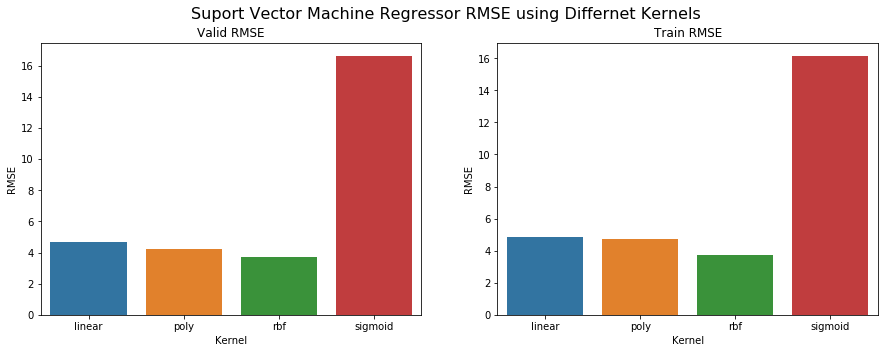

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Suport Vector Machine Regressor RMSE using Differnet Kernels', fontsize=16)

sns.barplot(ax=axes[0], x=kernels, y=valid_scores)
axes[0].set_title('Valid RMSE')
axes[0].set_xlabel('Kernel')
axes[0].set_ylabel('RMSE')

sns.barplot(ax=axes[1], x=kernels, y=train_scores)
axes[1].set_title('Train RMSE')
axes[1].set_xlabel('Kernel')
axes[1].set_ylabel('RMSE')
plt.show()

### K Nearst Neighbors
Training Different **K Nearst Neighbors** by changing the `n_neighbors` parameter

In [26]:
train_scores = []
valid_scores = []

best_valid = np.inf
best_knn = None

n_neighbors = range(2, 10, 1)

j = 0
for i in n_neighbors:
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(x_train, y_train);
    train_score = rmse_scorer(knn, x_train, y_train)
    valid_score = rmse_scorer(knn, x_valid, y_valid)
    train_scores.append(train_score)
    valid_scores.append(valid_score) 
    print(f"Iteration: {j+1}\t | # neighbors: {i}\t | train score: {train_score:.4f}\t | valid score: {valid_score:.4f}")
    j+=1

    # keeping the best model on the valid dataset
    if valid_score < best_valid:
        best_valid = valid_score
        best_knn = knn

Iteration: 1	 | # neighbors: 2	 | train score: 1.4281	 | valid score: 2.3185
Iteration: 2	 | # neighbors: 3	 | train score: 1.5982	 | valid score: 2.7559
Iteration: 3	 | # neighbors: 4	 | train score: 2.1239	 | valid score: 3.0944
Iteration: 4	 | # neighbors: 5	 | train score: 2.4357	 | valid score: 3.3031
Iteration: 5	 | # neighbors: 6	 | train score: 2.6484	 | valid score: 3.4796
Iteration: 6	 | # neighbors: 7	 | train score: 2.8526	 | valid score: 3.6281
Iteration: 7	 | # neighbors: 8	 | train score: 3.0359	 | valid score: 3.7287
Iteration: 8	 | # neighbors: 9	 | train score: 3.1773	 | valid score: 3.7452


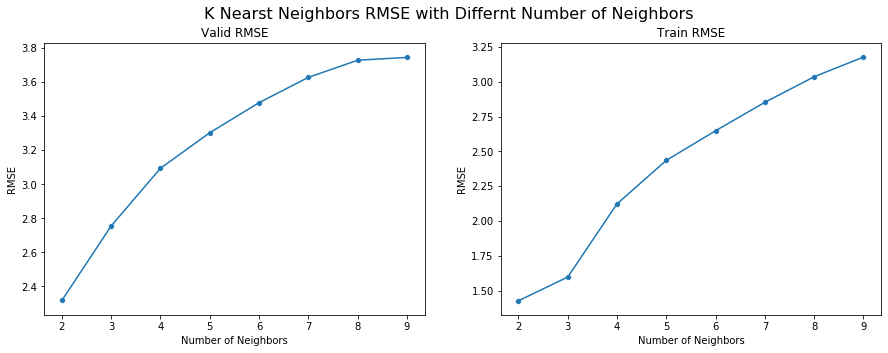

In [27]:
n_x = n_neighbors

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('K Nearst Neighbors RMSE with Differnt Number of Neighbors', fontsize=16)
sns.scatterplot(ax=axes[0], x=n_x, y=valid_scores)
sns.lineplot(ax=axes[0], x=n_x, y=valid_scores)
axes[0].set_title('Valid RMSE')
axes[0].set_xlabel('Number of Neighbors')
axes[0].set_ylabel('RMSE')

sns.scatterplot(ax=axes[1], x=n_x, y=train_scores)
sns.lineplot(ax=axes[1], x=n_x, y=train_scores)
axes[1].set_title('Train RMSE')
axes[1].set_xlabel('Number of Neighbors')
axes[1].set_ylabel('RMSE')
plt.show()

# Learning Curves 
Plotting the learning curve using **The models with the best parameters**

In [28]:
rf = best_rf
svr = best_svr
knn = best_knn

train_sizes_rf, train_scores_rf, valid_scores_rf, *_ = learning_curve(rf, x, y, scoring=rmse_scorer, n_jobs=-1,
                                                        random_state=42, cv=3)

train_sizes_svr, train_scores_svr, valid_scores_svr, *_ = learning_curve(svr, x, y, scoring=rmse_scorer, n_jobs=-1,
                                                        random_state=42, cv=3)

train_sizes_knn, train_scores_knn, valid_scores_knn, *_ = learning_curve(knn, x, y, scoring=rmse_scorer, n_jobs=-1,
                                                        random_state=42, cv=3)

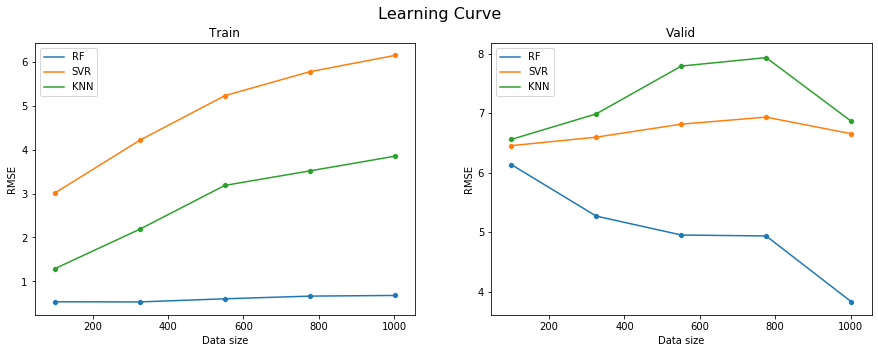

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Learning Curve', fontsize=16)
# The Training Plots
sns.scatterplot(ax=axes[0], x=train_sizes_rf, y=train_scores_rf.mean(axis=1))
sns.lineplot(ax=axes[0], x=train_sizes_rf, y=train_scores_rf.mean(axis=1))
sns.scatterplot(ax=axes[0], x=train_sizes_svr, y=train_scores_svr.mean(axis=1))
sns.lineplot(ax=axes[0], x=train_sizes_svr, y=train_scores_svr.mean(axis=1))
sns.scatterplot(ax=axes[0], x=train_sizes_knn, y=train_scores_knn.mean(axis=1))
sns.lineplot(ax=axes[0], x=train_sizes_knn, y=train_scores_knn.mean(axis=1))
axes[0].set_title('Train')
axes[0].set_xlabel('Data size')
axes[0].set_ylabel('RMSE')
axes[0].legend(['RF', 'SVR', 'KNN'])

# The Validation Plots
sns.scatterplot(ax=axes[1], x=train_sizes_rf,y=valid_scores_rf.mean(axis=1))
sns.lineplot(ax=axes[1], x=train_sizes_rf,y=valid_scores_rf.mean(axis=1))
sns.scatterplot(ax=axes[1], x=train_sizes_svr,y= valid_scores_svr.mean(axis=1))
sns.lineplot(ax=axes[1], x=train_sizes_svr,y= valid_scores_svr.mean(axis=1))
sns.scatterplot(ax=axes[1], x=train_sizes_knn, y=valid_scores_knn.mean(axis=1))
sns.lineplot(ax=axes[1], x=train_sizes_knn,y= valid_scores_knn.mean(axis=1))
axes[1].set_title('Valid')
axes[1].set_xlabel('Data size')
axes[1].set_ylabel('RMSE')
axes[1].legend(['RF', 'SVR', 'KNN'])
plt.show()

In [30]:
# best scores
# SVR
svr = SVR()
svr.fit(x_train, y_train)
svr_train_score = rmse_scorer(svr, x_train, y_train)
svr_valid_score = rmse_scorer(svr, x_valid, y_valid)
svr_valid_score_r2 = r2_score(svr.predict(x_valid), y_valid)
svr_mae_score = mean_absolute_error(svr.predict(x_valid), y_valid)

# KNN
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)
knn_train_score = rmse_scorer(knn, x_train, y_train)
knn_valid_score = rmse_scorer(knn, x_valid, y_valid)
knn_valid_score_r2 = r2_score(knn.predict(x_valid), y_valid)
knn_mae_score = mean_absolute_error(knn.predict(x_valid), y_valid)

# RandomForest
rf = RandomForestRegressor(n_estimators=160, criterion='mae', n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)
rf_train_score = rmse_scorer(rf, x_train, y_train)
rf_valid_score = rmse_scorer(rf, x_valid, y_valid)
rf_valid_score_r2 = r2_score(rf.predict(x_valid), y_valid)
rf_mae_score = mean_absolute_error(rf.predict(x_valid), y_valid)

In [31]:
model_performance = pd.DataFrame({
    'Model': ['SVR', 'KNN', 'RF'],
    'Train RMSE': [svr_train_score, knn_train_score, rf_train_score],
    'Valid RMSE': [svr_valid_score, knn_valid_score, rf_valid_score],
    'Valid MAE': [svr_mae_score, knn_mae_score, rf_mae_score],
    'Valid R2': [svr_valid_score_r2, knn_valid_score_r2, rf_valid_score_r2]
})

model_performance.sort_values(by="Valid RMSE")

,Model,Train RMSE,Valid RMSE,Valid MAE,Valid R2
2,RF,0.731027,1.791613,1.287403,0.921480
1,KNN,1.428145,2.318478,1.590794,0.869797
0,SVR,3.714375,3.721318,2.831572,0.535294
